# MEFE - TP computacional 3

**Tomás Di Napoli**

Este trabajo es la resolución del tercer TP computacional de [MEFE](http://materias.df.uba.ar/meefea2023c1/), cuya consigna se puede ver [acá](http://materias.df.uba.ar/meefea2023c1/files/2012/07/Test_de_Hip%C3%B3tesis_MEFE_2023_Madres21.pdf). También tiene su versión en [Jupyter Notebook]() junto con otros ejercicios de la materia que estoy subiendo a [este](https://github.com/tdinapoli/mefe/) repositorio de github.

Primero que nada importo las librerías que voy a usar y configuro el estilo de los gráficos

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn')
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

/tmp/ipykernel_24592/4046873007.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


El problema consiste en hacer un test de hipótesis para determinar si la cantidad de hijas que tienen las levaduras por unidad de tiempo es constante o no en el tiempo. Entonces, a hipótesis nula **$H_0$ es: la tasa de nacimientos es independiente del tiempo.**

Según dice la consigna, el número de hijas que tiene una célula de levadura durante toda su vida tiene una distribución de probabilidad 
$$Weibull(x \mid \lambda, \alpha) = \lambda \alpha (\lambda x)^{\alpha - 1} e^{-(\lambda x)^\alpha} $$
con $\lambda = 1/30$ y $\alpha=1$ en el caso de que la tasa de nacimientos es independiente del tiempo, y la misma distribución pero con $\alpha=0.8$ en el caso en el que esa tasa decrece en el tiempo. Primero que nada entonces visualizo estas distribuciones y las comparo en un gráfico.

In [2]:
# Defino los parámetros
lmbd = 1/30
alpha1 = 1
alpha2 = 0.8
# Creo las variables aleatorias (por cómo está definido debo poner 1/lambda en la escala)
wbc = ss.weibull_min(alpha1, scale=1/lmbd, loc=0)
wbd = ss.weibull_min(alpha2, scale=1/lmbd, loc=0)

Genero dos muestras de 100 mediciones de cada una de las variables aleatorias.

In [3]:
# Genero muestras de 100 datos de cada distribución
samplec = wbc.rvs(size=100)
sampled = wbd.rvs(size=100)

Ahora grafico las pdf de las variables aleatorias entre los valores de $x$ para los cuales la cdf es 0.01 y 0.99.

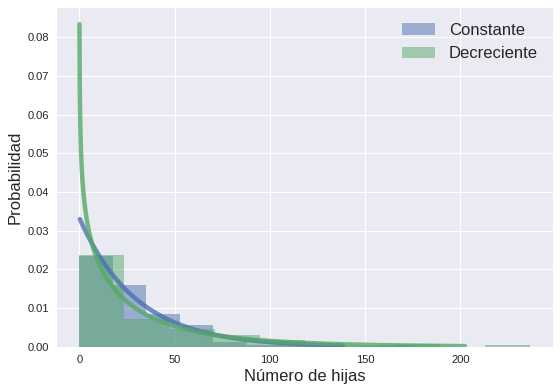

In [4]:
# Genero los x para graficar
x1 = np.linspace(wbc.ppf(0.01), wbc.ppf(0.99), 1000)
x2 = np.linspace(wbd.ppf(0.01), wbd.ppf(0.99), 1000)

# Grafico los histogramas normalizados
freq, bin_edges = np.histogram(samplec, density=True)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C0", label="Constante")
freq, bin_edges = np.histogram(sampled, density=True)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C1", label="Decreciente")

# Grafico las distribuciones sobre los histogramas.
plt.plot(x1, wbc.pdf(x1), lw=4, alpha=0.8, color="C0")
plt.plot(x2, wbd.pdf(x2), lw=4, alpha=0.8, color="C1")
plt.legend()
plt.xlabel("Número de hijas")
plt.ylabel("Probabilidad")
plt.show()

Al ser exponenciales, quizás es mejor visualizar esto con escala logarítmica en el eje y. Repito todo pero pongo plt.yscale("log") al final.

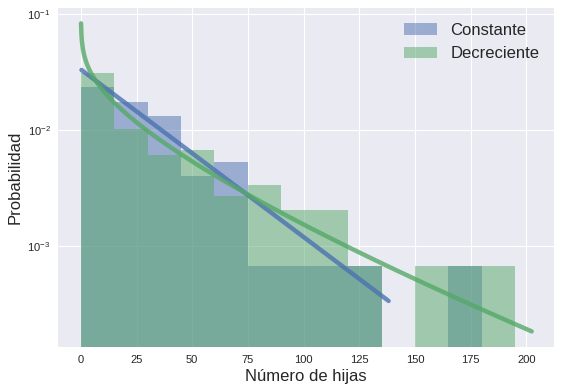

In [5]:
# Genero los x para graficar
x1 = np.linspace(wbc.ppf(0.01), wbc.ppf(0.99), 1000)
x2 = np.linspace(wbd.ppf(0.01), wbd.ppf(0.99), 1000)

# Grafico los histogramas normalizados
bins = np.arange(0, 201, 15, dtype=int)
freq, bin_edges = np.histogram(samplec, density=True, bins=bins)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C0", label="Constante")
freq, bin_edges = np.histogram(sampled, density=True, bins=bins)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C1", label="Decreciente")

# Grafico las distribuciones sobre los histogramas.
plt.plot(x1, wbc.pdf(x1), lw=4, alpha=0.8, color="C0")
plt.plot(x2, wbd.pdf(x2), lw=4, alpha=0.8, color="C1")
plt.legend()
plt.xlabel("Número de hijas")
plt.ylabel("Probabilidad")
plt.yscale("log")
plt.show()

In [6]:
def likelyhood(sample, rv):
    lhood = 1
    for measurement in sample:
        lhood = lhood * rv.pdf(measurement)
    return lhood

def log_likelyhood(sample, rv):
    loglhood = 1
    for measurement in sample:
        loglhood += np.log(rv.pdf(measurement))
    return loglhood


In [11]:
a = ss.weibull_min.fit(samplec, fscale=1/lmbd, floc=0)
a = ss.weibull_min.fit(sampled, fscale=1/lmbd, floc=0)
b = ss.weibull_min.fit(samplec)
print(a)
print(b)

(0.743403847351104, 0, 30.0)
(0.9374490004198228, 4.026752911304608, 24.411047562818556)
